# Molecular Fingerprints

Molecular fingerprints are a way of enconding a molecular feature into a binary format.

They are widely used in cheminformatics for various tasks such as **similarity searching, virtual screening, and clustering** of compound databases.

Fingerprint similarity search is valuable in virtual screening especially when limited unrelated ligands are known, making advanced methods like pharmacophore searches or structure-based design unsuitable. Additionally, these methods help evaluate compound collections for chemical diversity, spatial density, and biological activity, guiding decisions on which compounds to test, buy, or include in virtual screenings or design.<sup>[1](http://dx.doi.org/10.1517/17460441.2016.1117070)</sup>

There are many different fingerprints, here are some of the most commonly used:

1. **Molecular ACCess System keys (MACCS) Keys:**<sup>[2](https://dx-doi-org.lama.univ-amu.fr/10.1021/ci010132r)</sup>
- A set of 166 predefined structural fragment keys.
- Use: Often used in similarity searches and virtual screening.


3. **Atom-Pair<sup>[3](https://doi.org/10.1021/ci00046a002)</sup> and Topological-Torsion Fingerprints:**<sup>[4](https://doi.org/10.1021/ci00054a008)</sup>
- Capture the presence of specific atom pairs or torsional angles in a molecule.
- Use: Useful for 3D molecular similarity.

4. **Morgan Fingerprints:**<sup>[5](https://doi.org/10.1021/c160017a018)</sup>
- Circular fingerprints implemented in RDKit.
- Use: Similarity searching and clustering.

5. **Avalon Fingerprints:**<sup>[6](http://dx.doi.org/10.1021/ci050413p)</sup>
- Uses a combination of hashed atom environments and a layered approach.
- Similarity searching and machine learning in cheminformatics.

6. **RDKit Fingerprint:**<sup>[7](https://greglandrum.github.io/rdkit-blog/posts/2023-01-18-fingerprint-generator-tutorial.html)</sup>
- This is RDKit's default topological fingerprint. It's based on the presence of specific patterns or paths in the molecule. The paths can range from size 1 (individual atoms) to size 7 (or more, but typically up to 7).
- Use: General-purpose similarity searching.

In [1]:
!pip install rdkit-pypi

In [2]:
!pip install mols2grid #to visualize in a grid

In [3]:
import pandas as pd
import numpy as np
import seaborn as sn

from rdkit import Chem
from rdkit.Chem import AllChem #Chemistry related RDKit module
from rdkit.Chem import rdMolDescriptors #Molecular descriptors with numerical values
from rdkit.Chem.Draw import IPythonConsole #Molecules visualization with Jupyter
from rdkit.Chem import Draw #2D depiction
from rdkit.Chem import rdDepictor #2D coordinate generation, consistency
from rdkit import DataStructs #RDKit data structure - binary fingerprints
from rdkit.Chem import PandasTools #RDKit with Pandas
import mols2grid #Molecule representation in a grid
IPythonConsole.ipython_useSVG = True #Molecules display in SGV in Jupyter
rdDepictor.SetPreferCoordGen(True) #Cleaner 2D coordinate generation

# Example from DataSet of Solubility Study

## Load Data

This dataset was taken from a publication about the solubility prediction. Here is the link: https://doi.org/10.1021/ci034243x

In [4]:
url = 'https://raw.githubusercontent.com/Stef0916/chemoinformatics-bioinformatics/main/solubility_prediction-2005/data/solubility_train_molecules.csv'
dataset = pd.read_csv(url)
dataset.shape

(1144, 4)

In [5]:
dataset.head()

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl


## Data Pre-processing

**Canonical SMILES**



In [6]:
def canonical_smiles(smiles):
    mols = [Chem.MolFromSmiles(smi) for smi in smiles] # Chem.MolFromSmiles Convert a SMILES to an RDKit molecule object
    smiles = [Chem.MolToSmiles(mol) for mol in mols] # Chem.MolToSmiles converts the molecule back into its canonical SMILES representation
    return smiles

In [7]:
# Canonical SMILES
canon_smiles = canonical_smiles(dataset['SMILES'])

In [8]:
# Put the smiles in the dataframe
dataset['SMILES'] = canon_smiles
dataset

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.180,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.000,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.740,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.480,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.040,-3.077,FC(F)(Cl)C(F)(Cl)Cl
...,...,...,...,...
1139,vamidothion,1.144,-1.446,CNC(=O)C(C)SCCSP(=O)(OC)OC
1140,Vinclozolin,-4.925,-4.377,C=CC1(C)OC(=O)N(c2cc(Cl)cc(Cl)c2)C1=O
1141,Warfarin,-3.893,-3.913,CC(=O)CC(c1ccccc1)c1c(O)c2ccccc2oc1=O
1142,Xipamide,-3.790,-3.642,Cc1cccc(C)c1NC(=O)c1cc(S(N)(=O)=O)c(Cl)cc1O


**Remove Missing Values**

In [9]:
dataset["SMILES"].isnull().sum()

0

**Remove Duplicates**

In [10]:
duplicated = dataset[dataset['SMILES'].duplicated()]['SMILES'].values
duplicated

array(['Clc1ccc(-c2cccc(Cl)c2Cl)cc1', 'Clc1ccc(-c2cc(Cl)ccc2Cl)cc1',
       'Clc1ccc(-c2ccccc2Cl)cc1', 'Brc1ccc2ccccc2c1', 'CCC(C)CCO',
       'CCC1(CCC(C)C)C(=O)NC(=O)NC1=O', 'Cc1ccc(NC(=O)N(C)C)cc1Cl',
       'CCOP(=S)(OCC)SC(CCl)N1C(=O)c2ccccc2C1=O',
       'ClC1=C(Cl)C2(Cl)C3C4CC(C5OC45)C3C1(Cl)C2(Cl)Cl',
       'CC12CCC3C(CCC4CC(O)CCC43C)C1CCC2=O',
       'CCOC1Oc2ccc(OS(C)(=O)=O)cc2C1(C)C', 'CCOC(=O)c1ccc(N)cc1',
       'CC12CCC(CC1)C(C)(C)O2', 'CN(C)C(=O)Nc1cccc(C(F)(F)F)c1',
       'OCC1OC(OC2C(CO)OC(O)C(O)C2O)C(O)C(O)C1O',
       'Cc1ncc([N+](=O)[O-])n1CCO',
       'CCN(CC)c1c([N+](=O)[O-])cc(C(F)(F)F)c(N)c1[N+](=O)[O-]',
       'COc1ccccc1O', 'Clc1ccc(C(c2ccc(Cl)cc2)C(Cl)Cl)cc1',
       'ClC(Cl)=C(c1ccc(Cl)cc1)c1ccc(Cl)cc1', 'Nc1ccc(-c2ccc(N)cc2)cc1',
       'CCC1(c2ccccc2)C(=O)NC(=O)NC1=O', 'CCC1(C(C)C)C(=O)NC(=O)NC1=O',
       'O=C1c2ccccc2Cc2ccccc2N1CCF', 'NC(=O)c1ccccc1O',
       'OCC(O)C(O)C(O)C(O)CO',
       'NS(=O)(=O)c1cc2c(cc1Cl)NC(C(Cl)Cl)NS2(=O)=O'], dtype=object)

In [11]:
dataset[dataset['SMILES'].isin(duplicated)].sort_values(by=['SMILES'])

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
192,2-Bromonapthalene,-4.400,-4.434,Brc1ccc2ccccc2c1
191,2-bromonaphthalene,-4.400,-4.434,Brc1ccc2ccccc2c1
55,"1,8-Cineole",-1.740,-2.579,CC12CCC(CC1)C(C)(C)O2
674,eucalyptol,-1.640,-2.579,CC12CCC(CC1)C(C)(C)O2
392,Androsterone,-4.402,-3.882,CC12CCC3C(CCC4CC(O)CCC43C)C1CCC2=O
629,Epiandrosterone,-4.160,-3.882,CC12CCC3C(CCC4CC(O)CCC43C)C1CCC2=O
288,3-Methyl-2-pentanol,-0.720,-1.381,CCC(C)CCO
289,3-Methyl-2-pentanol,-0.710,-1.308,CCC(C)CCO
338,5-Ethyl-5-isopropylbarbituric acid,-2.148,-1.603,CCC1(C(C)C)C(=O)NC(=O)NC1=O
981,probarbital,-2.210,-1.603,CCC1(C(C)C)C(=O)NC(=O)NC1=O


In [12]:
dataset.shape

(1144, 4)

In [13]:
dataset_no_dup = dataset.drop_duplicates(subset=['SMILES'], keep='first').copy()

In [14]:
dataset_no_dup.shape

(1117, 4)

In [15]:
dataset_no_dup

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.180,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.000,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.740,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.480,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.040,-3.077,FC(F)(Cl)C(F)(Cl)Cl
...,...,...,...,...
1139,vamidothion,1.144,-1.446,CNC(=O)C(C)SCCSP(=O)(OC)OC
1140,Vinclozolin,-4.925,-4.377,C=CC1(C)OC(=O)N(c2cc(Cl)cc(Cl)c2)C1=O
1141,Warfarin,-3.893,-3.913,CC(=O)CC(c1ccccc1)c1c(O)c2ccccc2oc1=O
1142,Xipamide,-3.790,-3.642,Cc1cccc(C)c1NC(=O)c1cc(S(N)(=O)=O)c(Cl)cc1O


In [16]:
dataset_no_dup.reset_index(drop=True, inplace=True)

In [17]:
dataset_no_dup

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.180,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.000,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.740,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.480,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.040,-3.077,FC(F)(Cl)C(F)(Cl)Cl
...,...,...,...,...
1112,vamidothion,1.144,-1.446,CNC(=O)C(C)SCCSP(=O)(OC)OC
1113,Vinclozolin,-4.925,-4.377,C=CC1(C)OC(=O)N(c2cc(Cl)cc(Cl)c2)C1=O
1114,Warfarin,-3.893,-3.913,CC(=O)CC(c1ccccc1)c1c(O)c2ccccc2oc1=O
1115,Xipamide,-3.790,-3.642,Cc1cccc(C)c1NC(=O)c1cc(S(N)(=O)=O)c(Cl)cc1O


**Remove Fragments**

In some cases, a single SMILES string can represent multiple disconnected chemical structures. These disconnected structures are separated by a period (.) in the SMILES notation.

In [18]:
len(str(dataset_no_dup['SMILES']).split('.'))

4

In [19]:
def get_longest_smiles(smiles_string):
    return max(str(smiles_string).split('.'), key=len)

# Modify the 'SMILES' column with the longest SMILES strings using .loc[]
dataset_no_dup.loc[:, 'SMILES'] = dataset_no_dup['SMILES'].apply(get_longest_smiles)

# Create a new DataFrame without modifying the original df5:
dataset_clean = dataset_no_dup.copy()

In [20]:
dataset_clean

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.180,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.000,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.740,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.480,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.040,-3.077,FC(F)(Cl)C(F)(Cl)Cl
...,...,...,...,...
1112,vamidothion,1.144,-1.446,CNC(=O)C(C)SCCSP(=O)(OC)OC
1113,Vinclozolin,-4.925,-4.377,C=CC1(C)OC(=O)N(c2cc(Cl)cc(Cl)c2)C1=O
1114,Warfarin,-3.893,-3.913,CC(=O)CC(c1ccccc1)c1c(O)c2ccccc2oc1=O
1115,Xipamide,-3.790,-3.642,Cc1cccc(C)c1NC(=O)c1cc(S(N)(=O)=O)c(Cl)cc1O


In [101]:
dataset_clean.to_csv('solubility_clean.csv', index=False)

## Visualization

In [21]:
mol_list = [Chem.MolFromSmiles(element) for element in dataset_clean['SMILES']]

In [22]:
len(mol_list)

1117

In [23]:
# Creat a DataFrame from the mol_list
df_mol_list = pd.DataFrame(mol_list, columns=['Molecule'])

In [24]:
df_mol_list.head()

,Molecule
0,<rdkit.Chem.rdchem.Mol object at 0x7de882ef0740>
1,<rdkit.Chem.rdchem.Mol object at 0x7de882ef0eb0>
2,<rdkit.Chem.rdchem.Mol object at 0x7de882ef0e40>
3,<rdkit.Chem.rdchem.Mol object at 0x7de882ef0f20>
4,<rdkit.Chem.rdchem.Mol object at 0x7de882ef0f90>


In [25]:
# Visualize the DataFrame of the molecules within a grid
mols2grid.display(df_mol_list,mol_col="Molecule")

MolGridWidget()

## DataFrame

In [26]:
df_molecules = dataset_clean[['SMILES']]

,SMILES,ROMol
0,ClCC(Cl)(Cl)Cl,
1,CC(Cl)(Cl)Cl,
2,ClC(Cl)C(Cl)Cl,
3,ClCC(Cl)Cl,
4,FC(F)(Cl)C(F)(Cl)Cl,
...,...,...
1112,CNC(=O)C(C)SCCSP(=O)(OC)OC,
1113,C=CC1(C)OC(=O)N(c2cc(Cl)cc(Cl)c2)C1=O,
1114,CC(=O)CC(c1ccccc1)c1c(O)c2ccccc2oc1=O,
1115,Cc1cccc(C)c1NC(=O)c1cc(S(N)(=O)=O)c(Cl)cc1O,

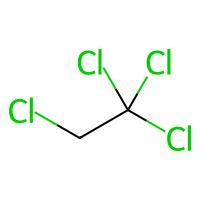
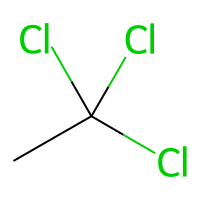
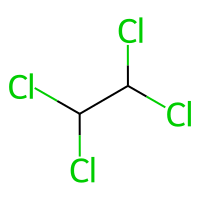
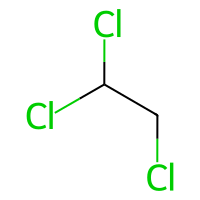
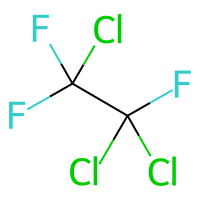
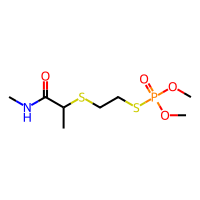
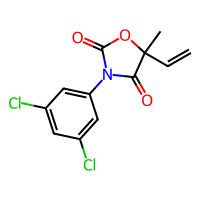
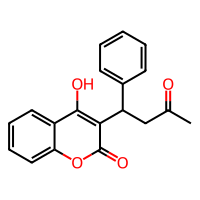
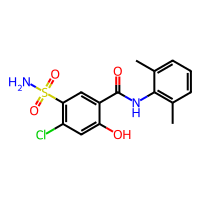
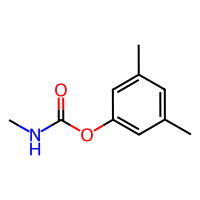

In [27]:
# using pandastools to create molecule from smiles within the dataframe
df_molecules = df_molecules.copy()
PandasTools.AddMoleculeColumnToFrame(df_molecules, "SMILES")
df_molecules

## Morgan Fingerprints

Morgan fingerprints are circular fingerprints, meaning they encode the environment around each atom in a molecule up to a certain radius. The radius determines how many bonds away from each atom the fingerprint considers. A radius of 2, for instance, would consider two bonds away from each atom.

**Chemical features:** Donor, Acceptor, Aromatic, Halogen, Basic, Acidi

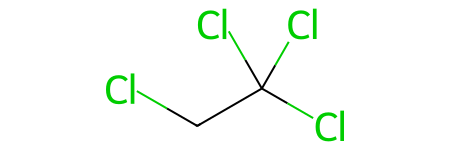

In [28]:
first_molecule = Chem.MolFromSmiles(dataset_clean.iloc[0]['SMILES'])
first_molecule

The `GetMorganFingerprintAsBitVect` function generates Morgan fingerprints, which are subsequently transformed into a numpy array. This vector consists of 0s and 1s: a '1' indicates the presence of a specific molecular feature, and a '0' denotes its absence.

In [29]:
bi ={}

fp = AllChem.GetMorganFingerprintAsBitVect(first_molecule, 2, nBits=2048, bitInfo=bi)
fp_arr = np.zeros((0,))
DataStructs.ConvertToNumpyArray(fp, fp_arr)
fp_arr

array([0., 0., 0., ..., 0., 0., 0.])

In [30]:
np.nonzero(fp_arr) # = list(fp.GetOnBits())

(array([  80,  106,  114,  244,  803, 1109, 1130, 1683]),)

In [31]:
list(fp.GetOnBits())

[80, 106, 114, 244, 803, 1109, 1130, 1683]

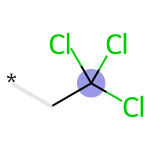

In [32]:
#Display the feature that turn a bit ON
Draw.DrawMorganBit(first_molecule, 106, bi)

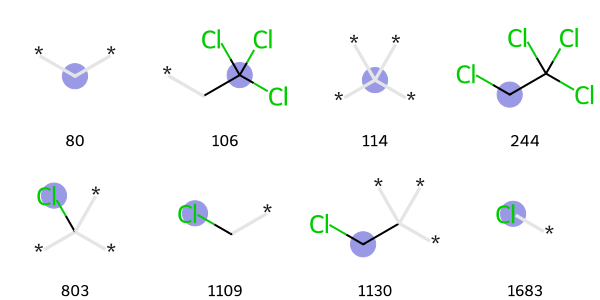

In [33]:
# From https://rdkit.blogspot.com/2018/10/using-new-fingerprint-bit-rendering-code.html
prints = [(first_molecule, x, bi) for x in fp.GetOnBits()]
Draw.DrawMorganBits(prints,molsPerRow=4,legends=[str(x) for x in fp.GetOnBits()])

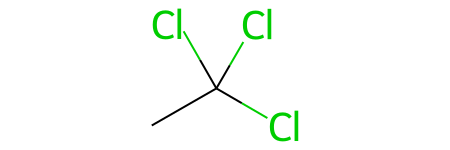

In [34]:
second_molecule = Chem.MolFromSmiles(dataset_clean.iloc[1]['SMILES'])
second_molecule

In [35]:
fp2 = AllChem.GetMorganFingerprintAsBitVect(second_molecule, 2, nBits=2048, bitInfo=bi)
list(fp2.GetOnBits())

[114, 392, 803, 1039, 1057, 1683]

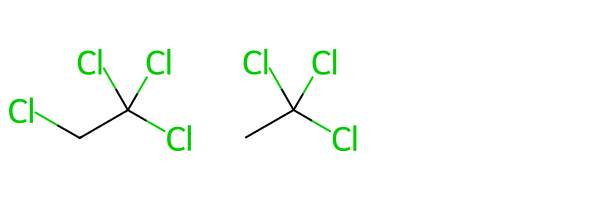

In [36]:
img = Draw.MolsToGridImage([first_molecule, second_molecule])
img

### Calculating similarity between fingerprints

#### Tanimoto Similarity (Jaccard Similarity)<sup>[8](http://dx.doi.org/10.1039/B409813G)</sup>

Tanimoto Similarity, often known as the Jaccard Similarity, is a measure used to compare the similarity and diversity of sample sets. In cheminformatics, it's frequently applied to compare molecular fingerprints, which are binary vectors signifying the presence or absence of particular molecular attributes. It's important to point that the relationship between molecular descriptors and biological activity isn't always linear, and the degree of similarity required for consistent behavior depends on the specific activity. Also, the inherent properties of binary molecular representations might have a big effect on similarity outcomes. For instance, amall structural alterations can cause notable shifts in molecular properties and receptor perception.<sup>[8](http://dx.doi.org/10.1039/B409813G)</sup>

The Tanimoto Similarity $T$ between two sets $A$ and $B$ (or two binary vectors) is given by:


$$T(A,B) = \frac{|A \cap B|}{|A \cup B|}$$


When applied to binary molecular fingerprints, this can be translated as:

$$T(f_1, f_2) = \frac{\text{number of bits set in both } f_1 \text{ and } f_2}{\text{number of bits set in either } f_1 \text{ or } f_2}$$

Where:
- $f_1$ and $f_2$ are two binary molecular fingerprints.
- The numerator counts the bits that are set (i.e., equal to 1) in both fingerprints.
- The denominator counts the bits that are set in either of the two fingerprints.

Tanimoto Similarity values span between 0 and 1:
- A value of 1 indicates the two fingerprints are identical.
- A value of 0 means the two fingerprints share no common bits.


In [37]:
print('first_molecule', list(fp.GetOnBits()))
print('second_molecule', list(fp2.GetOnBits()))

first_molecule [80, 106, 114, 244, 803, 1109, 1130, 1683]
second_molecule [114, 392, 803, 1039, 1057, 1683]


In [38]:
DataStructs.TanimotoSimilarity(fp, fp2)

0.2727272727272727

In [39]:
DataStructs.FingerprintSimilarity(fp,fp2) # = TanimotoSimilarity

0.2727272727272727

However, `FingerprintSimilarity` function can compute different types of similarity coefficients depending on an optional third argument (e.g., Dice, Cosine, etc.). If no third argument is provided, it defaults to Tanimoto.

In [40]:
print(f"The DiceSimilarity between first and second molecule is: {DataStructs.FingerprintSimilarity(fp,fp2, metric=DataStructs.DiceSimilarity)}")
print(f"The CosineSimilarity between first and second molecule is: {DataStructs.FingerprintSimilarity(fp,fp2, metric=DataStructs.CosineSimilarity)}")
print(f"The TanimotoSimilarity between first and second molecule is: {DataStructs.FingerprintSimilarity(fp,fp2)}")

The DiceSimilarity between first and second molecule is: 0.42857142857142855
The CosineSimilarity between first and second molecule is: 0.43301270189221935
The TanimotoSimilarity between first and second molecule is: 0.2727272727272727


**So, let's generalize to our dataset**

**Let's apply it to the whole dataset**

**Option 1**


---

In [41]:
df_morgan = df_molecules.copy()
df_morgan['Morgan'] = df_morgan['ROMol'].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x, radius=2, nBits=2048))
df_morgan

,SMILES,ROMol,Morgan
0,ClCC(Cl)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7de882ef3d80>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CC(Cl)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7de882ef1e00>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,ClC(Cl)C(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7de882ef2030>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,ClCC(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7de882ef2180>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,FC(F)(Cl)C(F)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7de882ef1ee0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
1112,CNC(=O)C(C)SCCSP(=O)(OC)OC,<rdkit.Chem.rdchem.Mol object at 0x7de882b8bca0>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1113,C=CC1(C)OC(=O)N(c2cc(Cl)cc(Cl)c2)C1=O,<rdkit.Chem.rdchem.Mol object at 0x7de882b8bd10>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1114,CC(=O)CC(c1ccccc1)c1c(O)c2ccccc2oc1=O,<rdkit.Chem.rdchem.Mol object at 0x7de882b8bd80>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1115,Cc1cccc(C)c1NC(=O)c1cc(S(N)(=O)=O)c(Cl)cc1O,<rdkit.Chem.rdchem.Mol object at 0x7de882b8bdf0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


**Option 2**


---

In [42]:
# Inspired from https://github.com/gashawmg/molecular-descriptors
def morgan_fpts(data, nBits=2048):
    """Generate Morgan fingerprints (circular fingerprints) for a list of SMILES strings.

    Parameters:
    - data (list of str): List of SMILES strings representing molecules.
    - nBits (int, optional): Desired size of the output fingerprint. Default is 2048 bits.

    Returns:
    - numpy.ndarray: An array where each row corresponds to the Morgan fingerprint of a molecule.
                     Each fingerprint is a binary array of size `nBits`.

    Note:
    - This function was inspired by: https://github.com/gashawmg/molecular-descriptors"""

    Morgan_fpts = []
    for smiles in data:
        mol = Chem.MolFromSmiles(smiles)
        fpts =  AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits)
        if mol:  # Ensure the molecule was correctly created
            mfpts = np.array(fpts)
            Morgan_fpts.append(mfpts)
    return np.array(Morgan_fpts)

In [43]:
morgan_fpts = morgan_fpts(df_molecules['SMILES'])
morgan_fpts.shape

(1117, 2048)

In [44]:
morgan_finpr = pd.DataFrame(morgan_fpts,columns=['Col_{}'.format(i) for i in range(morgan_fpts.shape[1])])
morgan_finpr

,Col_0,Col_1,Col_2,Col_3,Col_4,Col_5,Col_6,Col_7,Col_8,Col_9,...,Col_2038,Col_2039,Col_2040,Col_2041,Col_2042,Col_2043,Col_2044,Col_2045,Col_2046,Col_2047
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1112,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1113,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1114,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1115,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Differences between the dataframes:**

- **Representation:** The primary difference is in the representation of the fingerprints. In df_morgan (option 1), the Avalon fingerprint for each molecule is stored as an object (**`ExplicitBitVect`**), while in morgan_finpr (option 2), the fingerprint is spread across 2048 columns as individual bits.
- **Data Accessibility:** The option 2 format is more amenable for direct numerical and machine learning analyses since the fingerprints are already spread out as individual features. In contrast, the option 1 requires further processing to convert the ExplicitBitVect objects into a numerical format suitable for analysis.

## Avalon Fingerprint

The Avalon fingerprint is a molecular fingerprinting method designed for fast similarity searching and cheminformatics machine learning. It uses a combination of hashed atom environments and a layered approach to generate binary fingerprints.

In [45]:
from rdkit.Avalon import pyAvalonTools

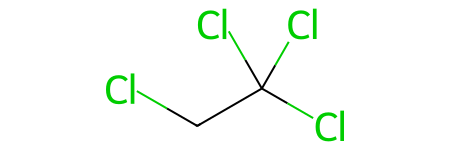

In [46]:
first_molecule = Chem.MolFromSmiles(dataset_clean.iloc[0]['SMILES'])
first_molecule

In [47]:
av_fpr1 = pyAvalonTools.GetAvalonFP(first_molecule, nBits=2048)
print(np.array(av_fpr1))

[0 1 0 ... 0 0 0]


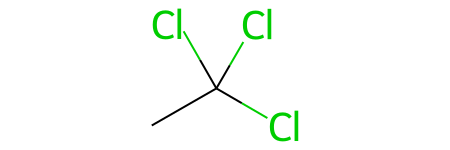

In [48]:
second_molecule = Chem.MolFromSmiles(dataset_clean.iloc[1]['SMILES'])
second_molecule

In [49]:
av_fpr2 = pyAvalonTools.GetAvalonFP(second_molecule, nBits=2048)
print(np.array(av_fpr2))

[0 1 0 ... 0 0 0]


In [50]:
print('first_molecule', list(av_fpr1.GetOnBits()))
print('second_molecule', list(av_fpr2.GetOnBits()))

first_molecule [1, 93, 97, 418, 427, 572, 579, 634, 649, 734, 1152, 1277, 1282, 1457, 1515, 1550, 1605, 1758, 1801, 1839, 1931]
second_molecule [1, 93, 97, 408, 418, 572, 579, 634, 649, 734, 1121, 1277, 1550, 1605, 1758, 1801, 1839]


Let's compute the Tanimoto Similarity

In [51]:
DataStructs.TanimotoSimilarity(av_fpr1, av_fpr2)

0.6521739130434783

**Let's apply it to the whole dataset**

**Option 1**


---

In [52]:
#For all the molecules of the DataFrame
df_avalon = df_molecules.copy()
df_avalon['Avalon'] = df_avalon['ROMol'].apply(lambda x: pyAvalonTools.GetAvalonFP(x, nBits=2048))
df_avalon

,SMILES,ROMol,Avalon
0,ClCC(Cl)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7de882ef3d80>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CC(Cl)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7de882ef1e00>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,ClC(Cl)C(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7de882ef2030>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,ClCC(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7de882ef2180>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,FC(F)(Cl)C(F)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7de882ef1ee0>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
1112,CNC(=O)C(C)SCCSP(=O)(OC)OC,<rdkit.Chem.rdchem.Mol object at 0x7de882b8bca0>,"[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1113,C=CC1(C)OC(=O)N(c2cc(Cl)cc(Cl)c2)C1=O,<rdkit.Chem.rdchem.Mol object at 0x7de882b8bd10>,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1114,CC(=O)CC(c1ccccc1)c1c(O)c2ccccc2oc1=O,<rdkit.Chem.rdchem.Mol object at 0x7de882b8bd80>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1115,Cc1cccc(C)c1NC(=O)c1cc(S(N)(=O)=O)c(Cl)cc1O,<rdkit.Chem.rdchem.Mol object at 0x7de882b8bdf0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


**Option 2**


---

In [53]:
def avalon_fps(data, nBits=2048): #To costume the desire nBits
    """Generate Avalon fingerprints for a list of SMILES strings.

    Parameters:
    - data (list of str): List of SMILES strings representing molecules.
    - nBits (int, optional): Desired size of the output fingerprint. Default is 2048 bits.

    Returns:
    - numpy.ndarray: An array where each row corresponds to the Avalon fingerprint of a molecule.
                     Each fingerprint is a binary array of size `nBits`."""
    Avalon_fps = []
    for smiles in data:
        mol = Chem.MolFromSmiles(smiles)
        if mol:  # Ensure the molecule was correctly created
            fp = pyAvalonTools.GetAvalonFP(mol, nBits)
            Avalon_fps.append(np.array(fp))
    return np.array(Avalon_fps)

In [54]:
avalon_fpts = avalon_fps(df_molecules['SMILES'])
avalon_fpts.shape

(1117, 2048)

In [55]:
avalon_finpr = pd.DataFrame(avalon_fpts,columns=['Col_{}'.format(i) for i in range(avalon_fpts.shape[1])])
avalon_finpr

,Col_0,Col_1,Col_2,Col_3,Col_4,Col_5,Col_6,Col_7,Col_8,Col_9,...,Col_2038,Col_2039,Col_2040,Col_2041,Col_2042,Col_2043,Col_2044,Col_2045,Col_2046,Col_2047
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1112,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1113,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1114,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1115,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Molecular ACCess System keys (MACCS) Keys

The MACCS fingerprint has a fixed length of 166 bits, with each bit corresponding to a specific pre-defined substructural feature.

In [56]:
from rdkit.Chem import MACCSkeys

In [57]:
#For the first molecule of the DataFrame
maccs_fp = MACCSkeys.GenMACCSKeys(df_molecules.ROMol[0])
print(np.array(maccs_fp))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0]


In [58]:
np.nonzero(maccs_fp)

(array([103, 106, 107, 112, 134, 153, 155]),)

In [59]:
#For the second molecule of the DataFrame
maccs_fp2 = MACCSkeys.GenMACCSKeys(df_molecules.ROMol[1])
print(np.array(maccs_fp2))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]


In [60]:
print('first_molecule', list(maccs_fp.GetOnBits()))
print('second_molecule', list(maccs_fp2.GetOnBits()))

first_molecule [103, 106, 107, 112, 134, 153, 155]
second_molecule [103, 106, 107, 112, 134, 160]


In [61]:
DataStructs.TanimotoSimilarity(maccs_fp, maccs_fp2)

0.625

**Let's generate the fingerprints for the whole dataset**

**Option 1**


---

In [62]:
#For all the molecules of the DataFrame
df_maccs = df_molecules.copy()
df_maccs['MACCS'] = df_maccs['ROMol'].apply(MACCSkeys.GenMACCSKeys)
df_maccs

,SMILES,ROMol,MACCS
0,ClCC(Cl)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7de882ef3d80>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CC(Cl)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7de882ef1e00>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,ClC(Cl)C(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7de882ef2030>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,ClCC(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7de882ef2180>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,FC(F)(Cl)C(F)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7de882ef1ee0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
1112,CNC(=O)C(C)SCCSP(=O)(OC)OC,<rdkit.Chem.rdchem.Mol object at 0x7de882b8bca0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1113,C=CC1(C)OC(=O)N(c2cc(Cl)cc(Cl)c2)C1=O,<rdkit.Chem.rdchem.Mol object at 0x7de882b8bd10>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1114,CC(=O)CC(c1ccccc1)c1c(O)c2ccccc2oc1=O,<rdkit.Chem.rdchem.Mol object at 0x7de882b8bd80>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1115,Cc1cccc(C)c1NC(=O)c1cc(S(N)(=O)=O)c(Cl)cc1O,<rdkit.Chem.rdchem.Mol object at 0x7de882b8bdf0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


**Option 2**


---

In [63]:
def maccs_fps(data):
    """Generate MACCS fingerprints for a list of SMILES strings.

    Parameters:
    - data (list of str): List of SMILES strings representing molecules.

    Returns:
    - numpy.ndarray: An array where each row corresponds to the MACCS fingerprint of a molecule.
                     Each fingerprint is a fixed-length (typically 166-bits) binary array."""

    MACCS_fps = []
    for smiles in data:
        mol = Chem.MolFromSmiles(smiles)
        if mol:  # Ensure the molecule was correctly created
            fp = MACCSkeys.GenMACCSKeys(mol)
            MACCS_fps.append(np.array(fp))
    return np.array(MACCS_fps)

In [64]:
maccs_fps = maccs_fps(df_molecules['SMILES'])
maccs_fps.shape

(1117, 167)

In [65]:
maccs_fps

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 0]])

In [66]:
maccs_fps = pd.DataFrame(maccs_fps,columns=['Col_{}'.format(i) for i in range(maccs_fps.shape[1])])
maccs_fps

,Col_0,Col_1,Col_2,Col_3,Col_4,Col_5,Col_6,Col_7,Col_8,Col_9,...,Col_157,Col_158,Col_159,Col_160,Col_161,Col_162,Col_163,Col_164,Col_165,Col_166
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1112,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,0,0,1,0,0
1113,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
1114,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,1,1,1,1,0
1115,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0


## Atom-Pairs Fingerprint

An atom pair substructure is defined as a triplet of two (non-hydrogen) atoms and their shortest path distance in the molecular graph, i.e. (atom type 1, atom type 2, geodesic distance). In the standard RDKit implementation, distinct atom types are defined by tuples of atomic number, number of heavy atom neighbours, aromaticity and chirality. All unique triplets in a molecule are enumerated and stored in sparse count or bit vector format.

In [67]:
from rdkit.Chem import rdMolDescriptors

In [68]:
ap_fp = rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(first_molecule, nBits=512)
print(np.array(ap_fp))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [69]:
ap_fp2 = rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(second_molecule, nBits=512)
print(np.array(ap_fp2))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [70]:
print('first_molecule', list(ap_fp.GetOnBits()))
print('second_molecule', list(ap_fp2.GetOnBits()))

first_molecule [40, 120, 121, 184, 185, 292, 293, 304, 372, 373, 444]
second_molecule [252, 253, 292, 293, 372, 373, 374]


In [71]:
DataStructs.TanimotoSimilarity(ap_fp, ap_fp2)

0.2857142857142857

**Let's generate the fingerprints for the whole dataset**

**Option 1**


---

In [72]:
#For all the molecules of the DataFrame
df_ap = df_molecules.copy()
df_ap['Atom-Pairs'] = df_ap['ROMol'].apply(lambda x: rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(x, nBits=2048))
df_ap

,SMILES,ROMol,Atom-Pairs
0,ClCC(Cl)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7de882ef3d80>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CC(Cl)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7de882ef1e00>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,ClC(Cl)C(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7de882ef2030>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,ClCC(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7de882ef2180>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,FC(F)(Cl)C(F)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7de882ef1ee0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
1112,CNC(=O)C(C)SCCSP(=O)(OC)OC,<rdkit.Chem.rdchem.Mol object at 0x7de882b8bca0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1113,C=CC1(C)OC(=O)N(c2cc(Cl)cc(Cl)c2)C1=O,<rdkit.Chem.rdchem.Mol object at 0x7de882b8bd10>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1114,CC(=O)CC(c1ccccc1)c1c(O)c2ccccc2oc1=O,<rdkit.Chem.rdchem.Mol object at 0x7de882b8bd80>,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1115,Cc1cccc(C)c1NC(=O)c1cc(S(N)(=O)=O)c(Cl)cc1O,<rdkit.Chem.rdchem.Mol object at 0x7de882b8bdf0>,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


**Option 2**


---

In [73]:
def ap_fps(data, nBits=2048):
    """
    Generate Hashed Topological Torsion fingerprints for a list of SMILES strings.

    Parameters:
    - data: List of SMILES strings.
    - nBits: Desired size of the output fingerprint. Default is 2048 bits.

    Returns:
    - A numpy array of TT fingerprints.
    """
    AP_fps = []
    for smiles in data:
        mol = Chem.MolFromSmiles(smiles)
        if mol:  # Ensure the molecule was correctly created
            fp = rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(mol, nBits=nBits)
            AP_fps.append(np.array(fp))
    return np.array(AP_fps)

In [74]:
ap_fps = ap_fps(df_molecules['SMILES'])
ap_fps.shape

(1117, 2048)

In [75]:
ap_fps

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [76]:
ap_fps = pd.DataFrame(ap_fps,columns=['Col_{}'.format(i) for i in range(ap_fps.shape[1])])
ap_fps

,Col_0,Col_1,Col_2,Col_3,Col_4,Col_5,Col_6,Col_7,Col_8,Col_9,...,Col_2038,Col_2039,Col_2040,Col_2041,Col_2042,Col_2043,Col_2044,Col_2045,Col_2046,Col_2047
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1112,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1113,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,0
1114,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1115,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


## Topological-Torsion Fingerprints

It captures information about a molecule based on the torsion angles between atoms.
It works with a sequence of four bonded atoms A−B−C−D in a molecule considering the atomic numbers and their connectivity. The TT descriptor captures local environment and connectivity information around each torsion in the molecule. The resulting fingerprint represents all the unique torsions in the molecule. They can be particularly useful when torsional angles play a crucial role in molecular activity or behavior, such as in specific types of molecular docking scenarios.

"They aim to complement the long-range relationships captured in atom pair fingerprints by representing short-range information contained in the torsion angles of a molecule."<sup>[8](https://www.blopig.com/blog/2022/06/exploring-topological-fingerprints-in-rdkit/)</sup>

In [77]:
from rdkit.Chem import rdMolDescriptors

In [78]:
tt_fp = rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(first_molecule, nBits=512)
print(np.array(tt_fp))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [79]:
#For the second molecule of the DataFrame
tt_fp2 = rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(second_molecule, nBits=512)
print(np.array(tt_fp2))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [80]:
print('first_molecule', list(tt_fp.GetOnBits()))
print('second_molecule', list(tt_fp2.GetOnBits()))

first_molecule [248, 249]
second_molecule []


In [81]:
DataStructs.TanimotoSimilarity(tt_fp, tt_fp2)

0.0

**Let's generate the fingerprints for the whole dataset**

**Option 1**


---

In [82]:
#For all the molecules of the DataFrame
df_tt = df_molecules.copy()
df_tt['Torsion'] = df_tt['ROMol'].apply(lambda x: rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(x, nBits=2048))
df_tt

,SMILES,ROMol,Torsion
0,ClCC(Cl)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7de882ef3d80>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CC(Cl)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7de882ef1e00>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,ClC(Cl)C(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7de882ef2030>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,ClCC(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7de882ef2180>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,FC(F)(Cl)C(F)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7de882ef1ee0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
1112,CNC(=O)C(C)SCCSP(=O)(OC)OC,<rdkit.Chem.rdchem.Mol object at 0x7de882b8bca0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1113,C=CC1(C)OC(=O)N(c2cc(Cl)cc(Cl)c2)C1=O,<rdkit.Chem.rdchem.Mol object at 0x7de882b8bd10>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1114,CC(=O)CC(c1ccccc1)c1c(O)c2ccccc2oc1=O,<rdkit.Chem.rdchem.Mol object at 0x7de882b8bd80>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ..."
1115,Cc1cccc(C)c1NC(=O)c1cc(S(N)(=O)=O)c(Cl)cc1O,<rdkit.Chem.rdchem.Mol object at 0x7de882b8bdf0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


**Option 2**


---

In [83]:
def tt_fps(data, nBits=2048):
    """
    Generate Hashed Topological Torsion fingerprints for a list of SMILES strings.

    Parameters:
    - data: List of SMILES strings.
    - nBits: Desired size of the output fingerprint. Default is 2048 bits.

    Returns:
    - A numpy array of TT fingerprints.
    """
    TT_fps = []
    for smiles in data:
        mol = Chem.MolFromSmiles(smiles)
        if mol:  # Ensure the molecule was correctly created
            fp = rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(mol, nBits=nBits)
            TT_fps.append(np.array(fp))
    return np.array(TT_fps)

In [84]:
tt_fps = tt_fps(df_molecules['SMILES'])
tt_fps.shape

(1117, 2048)

In [85]:
tt_fps

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [86]:
tt_fps = pd.DataFrame(tt_fps,columns=['Col_{}'.format(i) for i in range(tt_fps.shape[1])])
tt_fps

,Col_0,Col_1,Col_2,Col_3,Col_4,Col_5,Col_6,Col_7,Col_8,Col_9,...,Col_2038,Col_2039,Col_2040,Col_2041,Col_2042,Col_2043,Col_2044,Col_2045,Col_2046,Col_2047
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1112,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1113,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1114,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1115,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## RDKit Fingerprints

From https://www.rdkit.org/docs/RDKit_Book.html#additional-information-about-the-fingerprints

This is an RDKit-specific fingerprint that is inspired by (though it differs significantly from) public descriptions of the Daylight fingerprint<sup>[9](http://www.daylight.com/dayhtml/doc/theory/theory.finger.html)</sup>.

**Features:**

- Path-Based: The fingerprint captures connectivity information, specifically all the paths in a molecule up to a certain length.
- Hashed Representation: The paths are typically hashed to a fixed-size bit vector, which means that the fingerprint has a predetermined length, and the paths are mapped to specific bits.
- Customizable: When generating this fingerprint, you can specify parameters like:
    * Maximum and minimum path lengths
    * Whether to include paths to hydrogen atoms with the **`useHs`**
    * Size of the fingerprint (number of bits)

In [87]:
from rdkit.Chem import RDKFingerprint

In [88]:
bi ={}

rdkit_fp = RDKFingerprint(first_molecule, maxPath=5, fpSize=512, bitInfo=bi)
rdkit_fp_arr = np.zeros((0,))
DataStructs.ConvertToNumpyArray(rdkit_fp, rdkit_fp_arr)
rdkit_fp_arr

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [89]:
np.nonzero(rdkit_fp_arr)

(array([134, 146, 155, 172, 176, 186, 236, 255, 271, 284, 292, 299, 317,
        343, 396, 435, 450, 475, 489, 510]),)

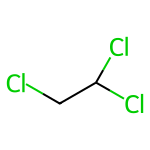

In [90]:
#Display the feature that turn a bit ON
Draw.DrawRDKitBit(first_molecule, 134, bi)

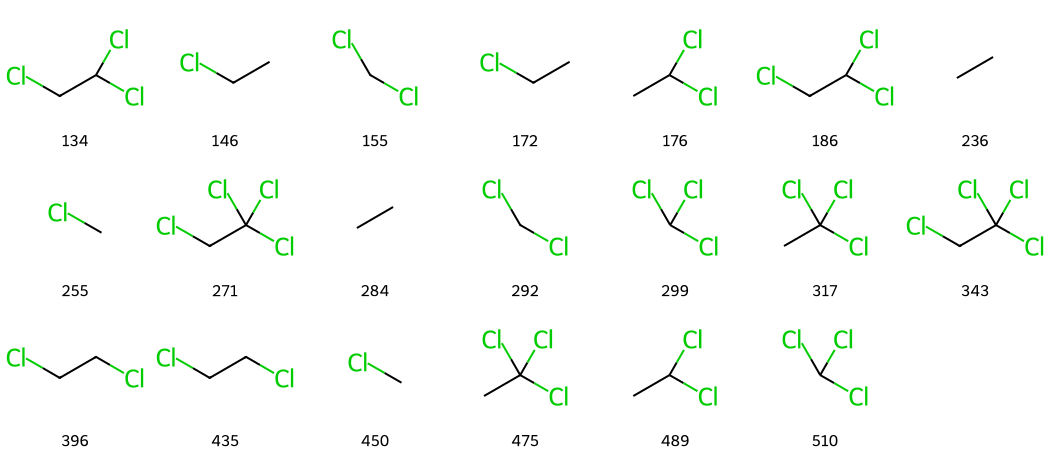

In [91]:
# From https://rdkit.blogspot.com/2018/10/using-new-fingerprint-bit-rendering-code.html
# Visualize more fragments
fragments = [(first_molecule, x, bi) for x in bi]
Draw.DrawRDKitBits(fragments,molsPerRow=7,legends=[str(x) for x in bi])

In [92]:
bi ={}

rdkit_fp2 = RDKFingerprint(second_molecule, maxPath=5, fpSize=512, bitInfo=bi)
rdkit_fp2_arr = np.zeros((0,))
DataStructs.ConvertToNumpyArray(rdkit_fp2, rdkit_fp2_arr)
rdkit_fp2_arr

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

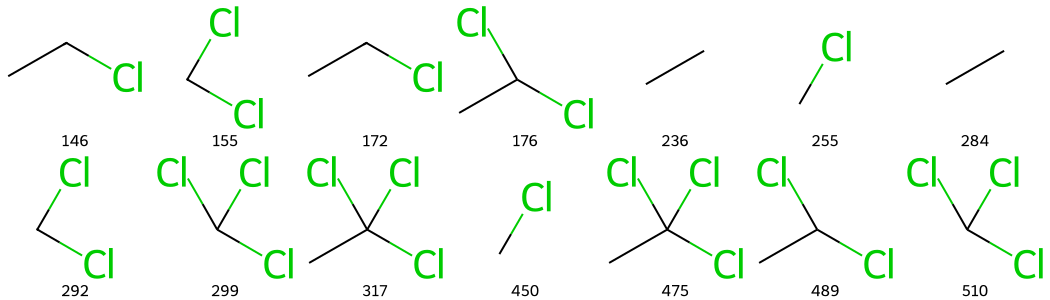

In [93]:
fragments = [(second_molecule, x, bi) for x in bi]
Draw.DrawRDKitBits(fragments,molsPerRow=7,legends=[str(x) for x in bi])

In [94]:
print('first_molecule', list(rdkit_fp.GetOnBits()))
print('second_molecule', list(rdkit_fp2.GetOnBits()))

first_molecule [134, 146, 155, 172, 176, 186, 236, 255, 271, 284, 292, 299, 317, 343, 396, 435, 450, 475, 489, 510]
second_molecule [146, 155, 172, 176, 236, 255, 284, 292, 299, 317, 450, 475, 489, 510]


In [95]:
DataStructs.TanimotoSimilarity(rdkit_fp, rdkit_fp2)

0.7

**Let's apply it to the whole dataset**

**Option 1**


---

In [96]:
df_rdkit = df_molecules.copy()
df_rdkit['RDKit'] = df_rdkit['ROMol'].apply(lambda x: RDKFingerprint(x, maxPath=5, fpSize=2048))
df_rdkit

,SMILES,ROMol,RDKit
0,ClCC(Cl)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7de882ef3d80>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CC(Cl)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7de882ef1e00>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,ClC(Cl)C(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7de882ef2030>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,ClCC(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7de882ef2180>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,FC(F)(Cl)C(F)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7de882ef1ee0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
1112,CNC(=O)C(C)SCCSP(=O)(OC)OC,<rdkit.Chem.rdchem.Mol object at 0x7de882b8bca0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
1113,C=CC1(C)OC(=O)N(c2cc(Cl)cc(Cl)c2)C1=O,<rdkit.Chem.rdchem.Mol object at 0x7de882b8bd10>,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1114,CC(=O)CC(c1ccccc1)c1c(O)c2ccccc2oc1=O,<rdkit.Chem.rdchem.Mol object at 0x7de882b8bd80>,"[1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1115,Cc1cccc(C)c1NC(=O)c1cc(S(N)(=O)=O)c(Cl)cc1O,<rdkit.Chem.rdchem.Mol object at 0x7de882b8bdf0>,"[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, ..."


**Option 2**


---

In [97]:
def rdkit_fps(data, nBits=2048, minPath=1, maxPath=7, useHs=True):
    """Generate RDKit fingerprints for a list of SMILES strings.

    Parameters:
    - data (list of str): List of SMILES strings representing molecules.
    - nBits (int, optional): Desired size of the output fingerprint. Default is 2048 bits.
    - minPath (int, optional): Minimum number of bonds to include in the subgraphs. Default is 1.
    - maxPath (int, optional): Maximum number of bonds to include in the subgraphs. Default is 7.
    - useHs (bool, optional): Include paths to hydrogen atoms. Default is True.

    Returns:
    - numpy.ndarray: An array where each row corresponds to the RDKit fingerprint of a molecule.
                     Each fingerprint is a binary array of size `nBits`."""
    RDKit_fps = []
    for smiles in data:
        mol = Chem.MolFromSmiles(smiles)
        if mol:  # Ensure the molecule was correctly created
            fp = RDKFingerprint(mol, maxPath=maxPath, minPath=minPath, fpSize=nBits, useHs=useHs)
            RDKit_fps.append(np.array(fp))
    return np.array(RDKit_fps)

In [98]:
rdkit_fps = rdkit_fps(df_molecules['SMILES'])
rdkit_fps.shape

(1117, 2048)

In [99]:
rdkit_fps

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 0, ..., 1, 1, 1],
       [0, 1, 1, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [100]:
rdkit_fps = pd.DataFrame(rdkit_fps,columns=['Col_{}'.format(i) for i in range(rdkit_fps.shape[1])])
rdkit_fps

,Col_0,Col_1,Col_2,Col_3,Col_4,Col_5,Col_6,Col_7,Col_8,Col_9,...,Col_2038,Col_2039,Col_2040,Col_2041,Col_2042,Col_2043,Col_2044,Col_2045,Col_2046,Col_2047
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1112,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1113,0,0,1,0,0,1,1,0,0,1,...,0,1,0,0,0,0,1,0,0,1
1114,1,1,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,0,1,1,1
1115,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
